In [2]:
%matplotlib notebook

import matplotlib as mpl
import pandas as pd
#import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# read file
dfTimeseries = pd.read_json("timeseries_results/alaska-refDiff.json")
dfStats = gp.read_file("regression_results/alaska-refDiff.gpkg")
dfTimeseries

NameError: name 'pd' is not defined

In [17]:
for idx, line in dfTimeseries.iloc[:2].iterrows():
    dates=[datetime.fromtimestamp(x/1000) for x in line['timeseries.dates']]


In [1]:
# plot preparation:

dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

coastline = gp.read_file('/data/puma1/scratch/mtngla/background-shapefiles/alaska/coastline.shp')

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)
vmin=-2
vmax=2
markersize = dfStats['statistics.GlacierMaskArea.pointsize']
labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]



NameError: name 'dfStats' is not defined

In [141]:
def plotDash(row):
    gridcellMinX = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minX']
    gridcellMinY = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minY']
    size = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.size']
    regression_line = dfStats[(dfStats['gridCell.minX']==gridcellMinX)&(dfStats['gridCell.minY']==gridcellMinY)]

    print('Glacier mask area: %.3f km' % (dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    print('Total points: %s' % (dfTimeseries.iloc[row]['statistics.result_total']))
    print('Points per km2: %s' % (dfTimeseries.iloc[row]['statistics.result_total']/dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    pdratio = dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask']/dfTimeseries.iloc[row]['statistics.result_total']*100
    print('Points on debris: %s  \t\t Points on debris ratio: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask'], pdratio))
    print('Points on TDX: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue2Ratio']))
    print('Points on AD: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue1Ratio']))
    print('Points on Interp: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue0Ratio']))

    print('RSquared: %.2f' % (regression_line['regression.rsquared']))
    print('Elevation change: %.3f m/year \t Robust elevation change: %.3f m/year' % (regression_line['regression.c.year'], regression_line['regression.robust.c.year']))
    print('Standard error: %.3f m \t\t Robust standard error: %.3f m ' % (regression_line['regression.c.se.year'], regression_line['regression.robust.c.se.year']))
    print('Regression constant: %.3f m \t\t Robust regression constant: %.3f m' % (regression_line['regression.const'],regression_line['regression.robust.const']))


    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(1,2,figsize=(9.8,5.5))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax[0])

    dfStats.plot(column='regression.robust.c.year', markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax[0])
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax[1], orientation='horizontal',  pad=0.35, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change per year [m/yr]')

    ax[0].legend(handles=markers)
    leg = ax[0].legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

    ax[0].set_xlim(-5000000, -2700000)
    ax[0].set_ylim(-900000, 1700000)
    # add number of gridcell
    for i, txt in enumerate(dfTimeseries['statistics.result_total']):
        ax[0].annotate(i, (dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)
    # add X
    ax[0].annotate('x', (gridcellMinX+(size/2)-30000, gridcellMinY+(size/2)-30000), fontsize=12)

    # time series
    ax[1].plot(dates , dfTimeseries.iloc[row]['timeseries.medians'], linewidth=0.7)

    ax[1].set_xlim(min(dates), max(dates))
    ax[1].set_xlabel('Years')
    ax[1].set_ylabel('Elevation change [m]')
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")

    plt.tight_layout()

Glacier mask area: 2635.782 km
Total points: 243208
Points per km2: 92.27165592907525
Points on debris: 10052  		 Points on debris ratio: 4.13 percent
Points on TDX: 52.88 percent
Points on AD: 45.09 percent
Points on Interp: 2.03 percent
RSquared: 0.00
Elevation change: -0.438 m/year 	 Robust elevation change: -0.209 m/year
Standard error: 0.026 m 		 Robust standard error: 0.014 m 
Regression constant: 23.878 m 		 Robust regression constant: 11.218 m


<IPython.core.display.Javascript object>


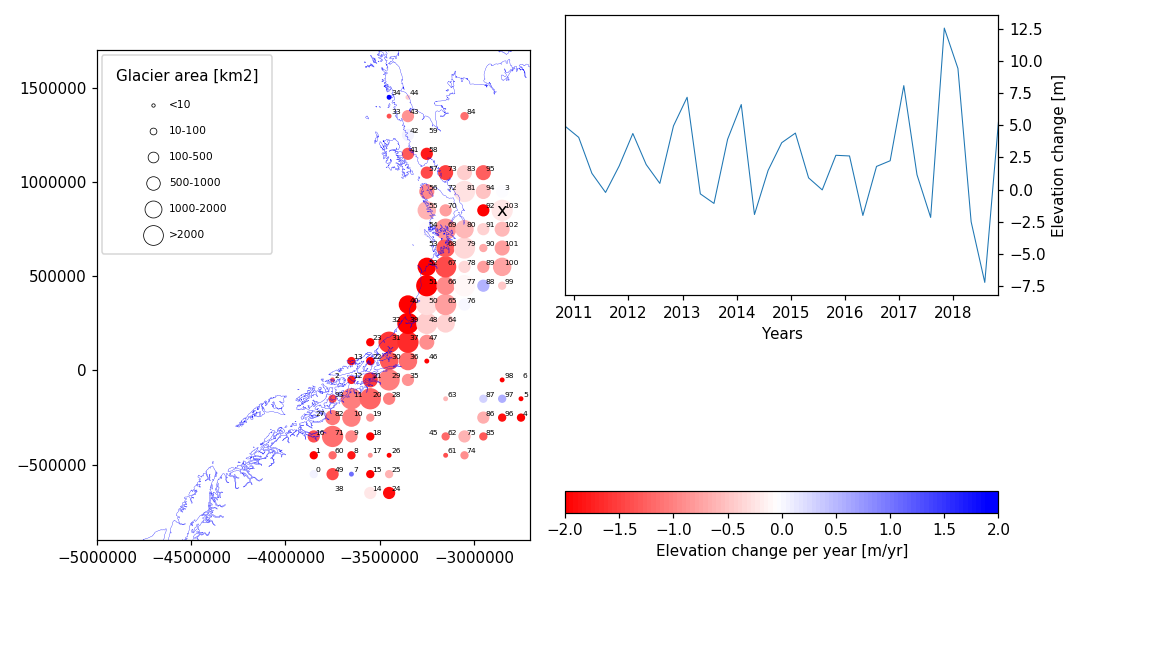

In [145]:
%matplotlib notebook
# change this
row=103
plotDash(row)

<IPython.core.display.Javascript object>


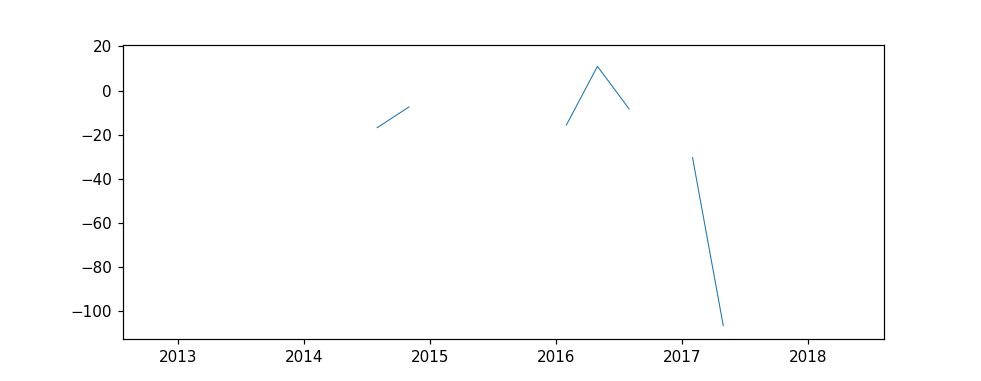

In [165]:
%matplotlib notebook
plt.figure(figsize=(9,3.5))

row=dfTimeseries.loc[(dfStats['gridCell.minX']==-3900000) & (dfStats['gridCell.minY']==-600000)]
 
dates=[datetime.fromtimestamp(x/1000) for x in row.iloc[0]['timeseries.dates']]
plt.plot(dates , row.iloc[0]['timeseries.averages'], linewidth=0.7)

In [83]:
def plotTS(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(8,5))
    # time series
    ax.plot(dates, dfTimeseries.iloc[row]['timeseries.medians'], linewidth=0.7)

    ax.set_xlim(min(dates), max(dates))
    ax.set_xlabel('Year')
    ax.set_ylabel('Median elevation difference to reference DEM [m]')
    #ax[1].yaxis.tick_right()
    #ax[1].yaxis.set_label_position("right")
    plt.title('3-Month time series with TandemX and ArcticDEM')

    plt.tight_layout()

<IPython.core.display.Javascript object>


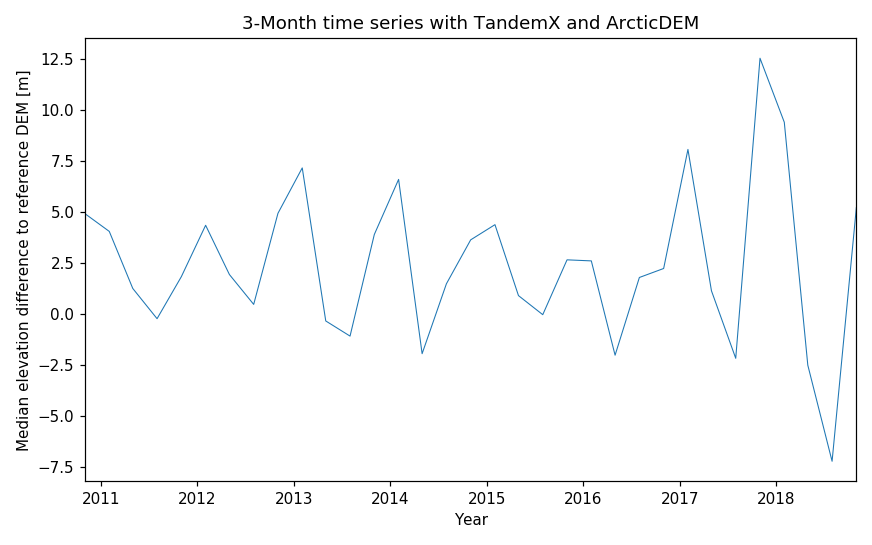

In [84]:
plotTS(row)

In [135]:
def plotMap(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(7,7))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)

    dfStats.plot(column='regression.robust.c.year', markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax, edgecolor='grey', linewidth=0.2)
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.05, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change [m/yr]')

    #ax.legend(handles=markers)
    #leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    #handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)
    #plt.title('DhDt Himalayas')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_xlim(-4700000, -2400000)
    ax.set_ylim(-920000, 1800000)

<IPython.core.display.Javascript object>


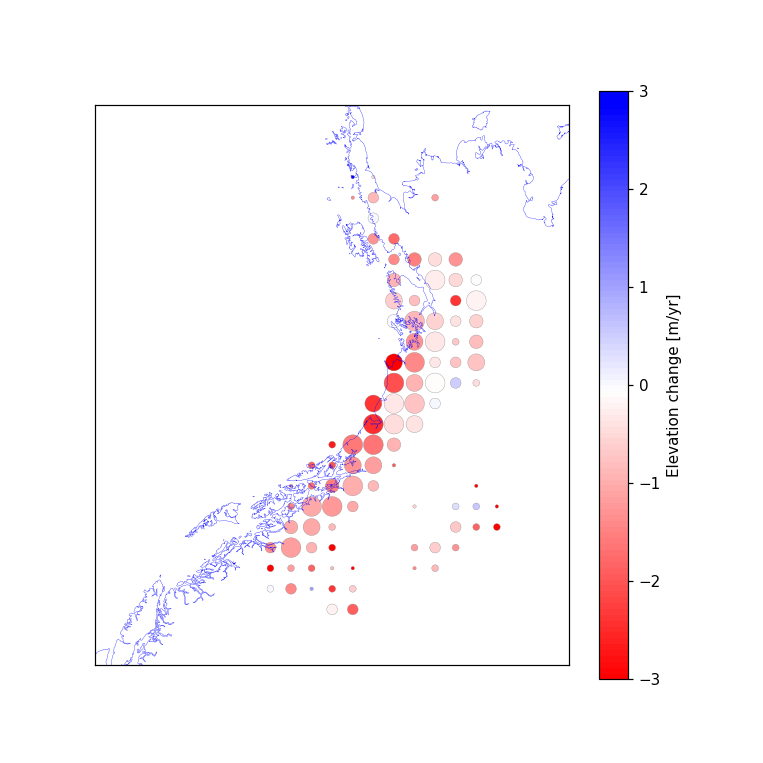

In [138]:
plotMap(row)